In [39]:
%matplotlib inline
import numpy as np
import cPickle
import mahotas as mh
import partition_comparison
import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))

In [16]:
def remove_synapse(img, threshold = 399):  
    for m in xrange(img.shape[0]):
        for n in xrange(img.shape[1]):
            if img[m,n] > threshold:
                img[m,n] = 0
    return img

def watershed(probs, radius):
    if probs.ndim == 3:
        shed = np.zeros(probs.shape,dtype=np.uint16)

        for n in xrange(probs.shape[0]):
            sel = disk(radius)
            minima = mh.regmin(probs[n], Bc=sel)
            markers, nr_markers = mh.label(minima)
            shed[n] = mh.cwatershed(probs[n], markers)

    else:
        sel = disk(radius)
        minima = mh.regmin(probs, Bc=sel)
        markers, nr_markers = mh.label(minima)
        shed = mh.cwatershed(probs, markers)

    return shed

def disk(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    return x**2 + y**2 <= radius**2

def partition_VI(putative, gold):
    mask = gold != 0
    VI_res = partition_comparison.variation_of_information(gold[mask], putative[mask].astype(gold.dtype))
    return VI_res

In [45]:
address1          = "../results/FC_super/"
pred_48x48         = np.load(address1 + "/results/output.npy")
y                = np.load(address1 + "/results/y.npy")
pred_window_size  = np.load(address1 + "/results/pred_window_size.npy")
gap = (pred_window_size[0]-pred_window_size[1])/2

# Load in test-addresses
address1          = "../results/48x48_2/"
f = file(address1 + "/pre_processed/" + "test_adress.dat", 'rb')
test_address = cPickle.load(f)
f.close()

ground_truth = np.zeros((10,pred_48x48.shape[1],pred_48x48.shape[2]),dtype=np.uint16)
n = 0
for address_img in test_address:
    ground_truth_new = mh.imread("../" +address_img)
    ground_truth[n] = ground_truth_new[gap:-gap,gap:-gap]
    ground_truth[n] = ground_truth[n].astype(np.uint16)
    ground_truth[n] = remove_synapse(ground_truth[n])
    n +=1

pred_48x48 = pred_48x48[-2:]
y = y[-2:]
ground_truth = ground_truth[-2:]

print pred_48x48.shape

(2, 962, 962)


In [29]:
def transpose(array):
    for n in xrange(array.shape[0]):
        array[n] = array[n].T
    return array

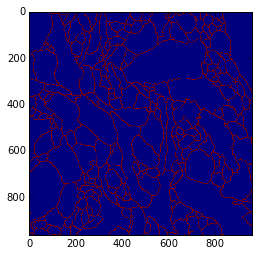

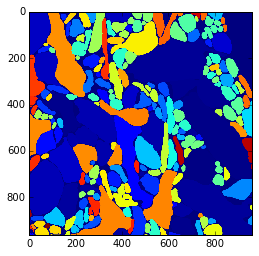

In [30]:
ground_truth = transpose(ground_truth)

plt.figure()
plt.imshow(y[0])
plt.figure()
plt.imshow(ground_truth[0])

### Example, probability map/ground truth

In [31]:
from gala import imio, classify, features, agglo, evaluate as ev

In [32]:
prob_map           = pred_48x48
wshed              = watershed(prob_map,5)

ground_truth_train = ground_truth[0]
prob_map_train     = prob_map[0]
watershed_train    = wshed[0]

ground_truth_test  = ground_truth[-1]
prob_map_test      = prob_map[-1]
watershed_test     = wshed[-1]

print ground_truth_train.shape
print prob_map_train.shape
print watershed_train.shape

print ground_truth_test.shape
print prob_map_test.shape
print watershed_test.shape

(962, 962)
(962, 962)
(962, 962)
(962, 962)
(962, 962)
(962, 962)


### Watershed

In [33]:
radii = np.linspace(7, 85, 15)
min_VI = 99.
for r in radii:
    wshed = watershed(prob_map_test,r)
    VI = partition_VI(wshed, ground_truth_test)
    if VI<min_VI:
        min_VI = VI
        watershed_map = wshed 

print "VI, watershed:",min_VI

VI, watershed: 1.74421961746






### GALA

In [34]:
# create a feature manager
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm,fh])

print "Starting agglo.."

g_train = agglo.Rag(watershed_train, prob_map_train,feature_manager=fc)

print "Making train set"

(X,y,w,merges) = g_train.learn_agglomerate(ground_truth_train,fc)[0]
y = y[:,0]

print "Training classifier"

rf = classify.DefaultRandomForest().fit(X, y)

Starting agglo..
Making train set
Training classifier


In [35]:
learned_policy = agglo.classifier_probability(fc, rf)

print "Predicting"

g_test = agglo.Rag(watershed_test,prob_map_test,learned_policy,feature_manager=fc)
g_test.agglomerate(0.5)
seg_test1 = g_test.get_segmentation()

print "VI gala:",partition_VI(seg_test1, ground_truth_test) 

Predicting
VI gala: 0.951450925536


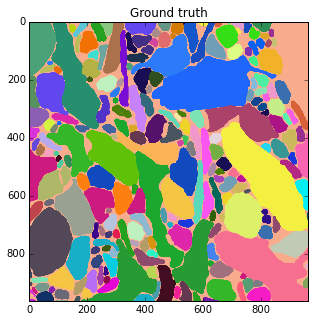

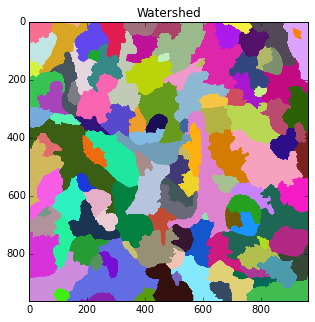

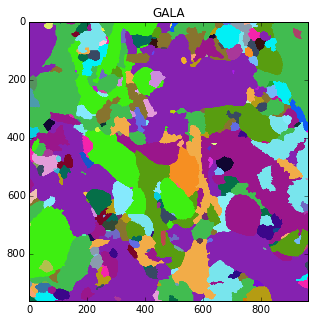

In [40]:
plt.figure(figsize=(5,5))
plt.title("Ground truth")
plt.imshow(ground_truth_test,cmap=cmap)
plt.figure(figsize=(5,5))
plt.title("Watershed")
plt.imshow(watershed_map,cmap=cmap)
#plt.savefig("wshed_seg.png")
plt.figure(figsize=(5,5))
plt.title("GALA")
plt.imshow(seg_test1,cmap=cmap)
#plt.savefig("gala_seg.png")

(2, 962, 962)
(2, 962, 962)


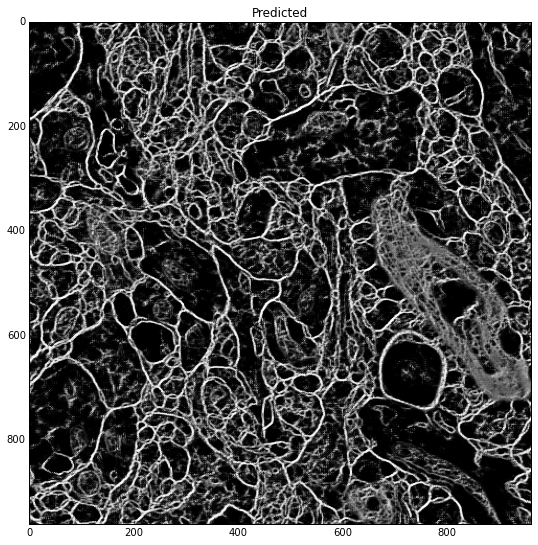

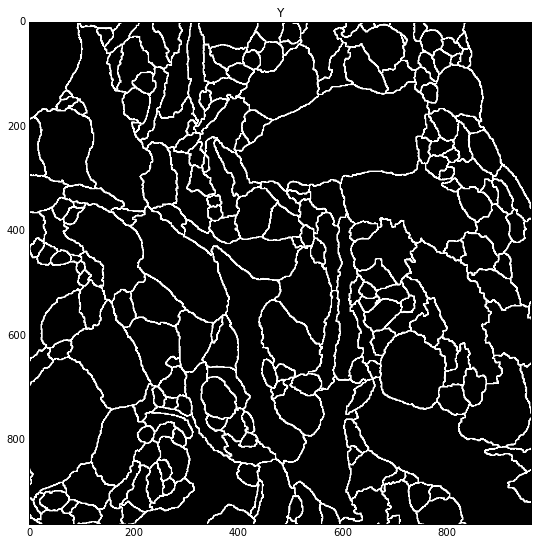

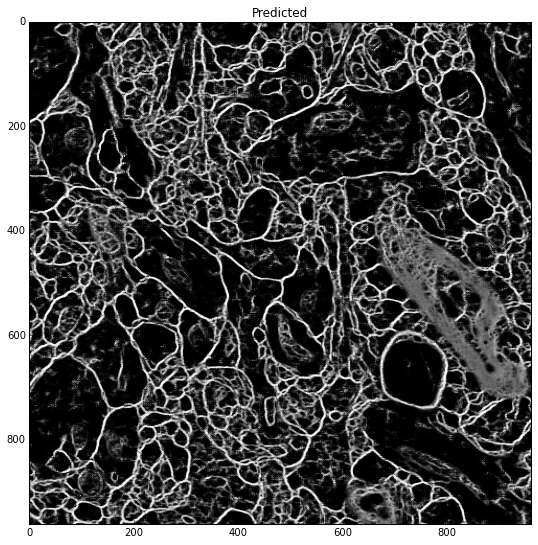

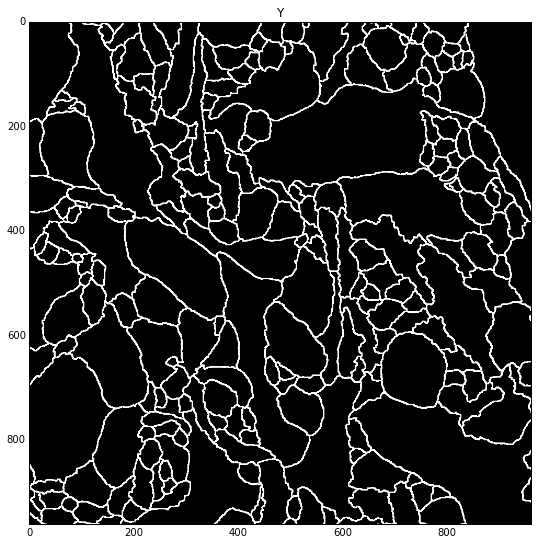

In [47]:
cmap = plt.cm.gray

for n in xrange(y.shape[0]):
    plt.figure(figsize=(9,9))
    plt.title("Predicted")
    plt.imshow(pred_48x48[n],cmap=cmap)
    plt.savefig("pred_fc4_" + str(n)) 
    
    print y.shape
    plt.figure(figsize=(9,9))
    plt.title("Y")
    plt.imshow(y[n],cmap=cmap)
    plt.savefig("y_fc4_" + str(n)) 

In [48]:
def watershed3d(probs, radius):
    sel = sphere(radius)
    minima = mh.regmin(probs, Bc=sel)
    markers, nr_markers = mh.label(minima)
    shed = mh.cwatershed(probs, markers)
    return shed

def sphere(radius):
    z,y,x = np.ogrid[-radius:radius+1, -radius:radius+1,-radius:radius+1]
    return (x**2 + y**2 + z**2 <= radius**2)*(z<(radius/5.))

In [ ]:
gt = ground_truth[-1]

radii = np.linspace(7, 85, 15)
for r in radii:
    wshed = watershed3d(prob_map[:2],r)
    print partition_VI(wshed[-1],gt)

3.82452692062
3.20204866848
2.8956922443